<a href="https://colab.research.google.com/github/Dhanasree07/Dhanasree/blob/main/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XGBoost:
TimeSeriesSplit CV Accuracy: 0.8944 ± 0.1015

LightGBM:
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 4638, number of used features: 15
[LightGBM] [Info] Start training from score -1.921417
[LightGBM] [Info] Start training from score -0.305228
[LightGBM] [Info] Start training from score -2.148619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

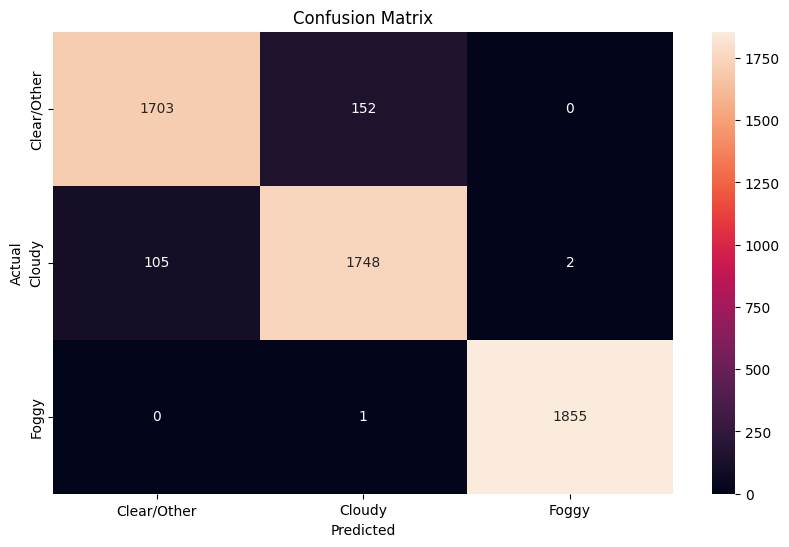

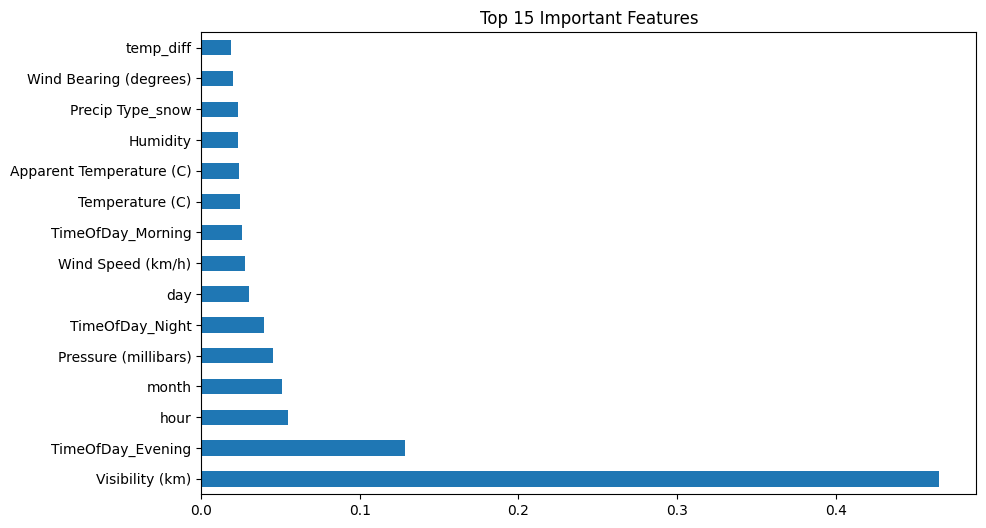


Classification model and encoder saved.

--- LSTM Temperature Forecasting ---
Epoch 1/10
277/277 - 5s - 18ms/step - loss: 0.0135 - val_loss: 0.0020
Epoch 2/10
277/277 - 5s - 19ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/10
277/277 - 3s - 10ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/10
277/277 - 3s - 10ms/step - loss: 9.1263e-04 - val_loss: 0.0013
Epoch 5/10
277/277 - 6s - 22ms/step - loss: 8.9776e-04 - val_loss: 0.0010
Epoch 6/10
277/277 - 4s - 15ms/step - loss: 7.8024e-04 - val_loss: 9.4585e-04
Epoch 7/10
277/277 - 3s - 10ms/step - loss: 7.3874e-04 - val_loss: 8.2946e-04
Epoch 8/10
277/277 - 3s - 11ms/step - loss: 6.9772e-04 - val_loss: 8.1381e-04
Epoch 9/10
277/277 - 5s - 18ms/step - loss: 6.3125e-04 - val_loss: 7.5651e-04
Epoch 10/10
277/277 - 3s - 10ms/step - loss: 6.2509e-04 - val_loss: 7.0711e-04
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
LSTM Temperature Forecasting RMSE: 1.537 °C


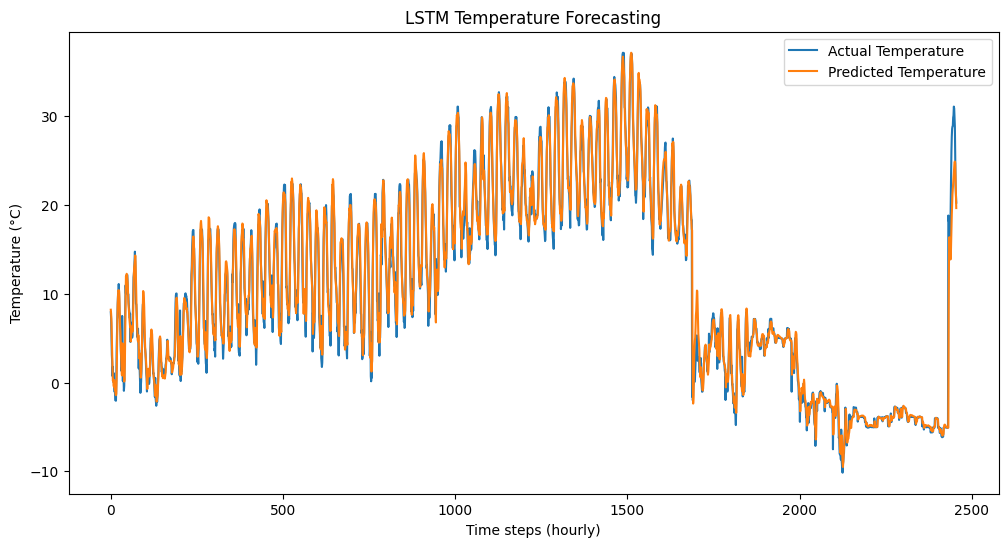

LSTM temperature model and scaler saved.


In [2]:
# Step 1: Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load dataset safely
file_path = '/content/weatherHistory.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File '{file_path}' not found. Please check the path and try again.")
df = pd.read_csv(file_path)

# Step 3: Initial Data Cleaning and Feature Engineering
if 'Formatted Date' in df.columns:
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
    df['month'] = df['Formatted Date'].dt.month
    df['day'] = df['Formatted Date'].dt.day
    df['hour'] = df['Formatted Date'].dt.hour

    # Time of day categorization
    def categorize_time(hour):
        if hour < 6:
            return 'Night'
        elif hour < 12:
            return 'Morning'
        elif hour < 18:
            return 'Afternoon'
        else:
            return 'Evening'

    df['TimeOfDay'] = df['hour'].apply(categorize_time)

# Temperature difference feature
if 'Temperature (C)' in df.columns and 'Apparent Temperature (C)' in df.columns:
    df['temp_diff'] = df['Temperature (C)'] - df['Apparent Temperature (C)']

# Drop unnecessary columns
df = df.drop(columns=['Loud Cover', 'Daily Summary'], errors='ignore')

# Fill missing values
df = df.fillna(method='ffill').dropna()

# Simplify weather summaries for classification target
def simplify_weather(summary):
    summary = summary.lower()
    if 'rain' in summary or 'drizzle' in summary:
        return 'Rainy'
    elif 'snow' in summary:
        return 'Snowy'
    elif 'fog' in summary:
        return 'Foggy'
    elif 'cloud' in summary or 'overcast' in summary:
        return 'Cloudy'
    elif 'windy' in summary:
        return 'Windy'
    elif 'dry' in summary:
        return 'Dry'
    elif 'humid' in summary:
        return 'Humid'
    else:
        return 'Clear/Other'

df['Simplified_Weather'] = df['Summary'].apply(simplify_weather)

# Encode target variable for classification
le = LabelEncoder()
df['weather_label'] = le.fit_transform(df['Simplified_Weather'])

# === Classification Task: Features & Target ===
X = df.drop(columns=['Summary', 'Simplified_Weather', 'weather_label'], errors='ignore')
y = df['weather_label']

# Drop datetime columns from features
X = X.drop(columns=X.select_dtypes(include=['datetime64[ns, UTC]', 'datetime64[ns]']).columns)

# One-hot encode categorical features
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=np.number).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Align target with features
y = y.loc[X.index]

# Filter out rare classes before SMOTE
min_samples = 6
class_counts = y.value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
X = X[y.isin(classes_to_keep)]
y = y[y.isin(classes_to_keep)]

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# === Updated Evaluation Function: Use TimeSeriesSplit for temporal awareness ===
def evaluate_model_cv(model, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X, y, cv=tscv, scoring='accuracy')
    print(f'TimeSeriesSplit CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

# Baseline models evaluation
print("XGBoost:")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
evaluate_model_cv(xgb, X_res, y_res)

print("\nLightGBM:")
lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=len(le.classes_), random_state=42)
evaluate_model_cv(lgbm, X_res, y_res)

print("\nRandom Forest (Optimized):")
rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
evaluate_model_cv(rf, X_res, y_res)

# Hyperparameter tuning for XGBoost with TimeSeriesSplit
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1]
}
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(xgb, param_grid, cv=tscv, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\nBest Params:", grid.best_params_)

# Final evaluation on test set
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).nlargest(15)
feat_imp.plot(kind='barh')
plt.title('Top 15 Important Features')
plt.show()

# Save model and encoder
joblib.dump(best_model, 'weather_model.pkl')
joblib.dump(le, 'weather_label_encoder.pkl')
print("\nClassification model and encoder saved.")

# ===== Add LSTM for Future Temperature Forecasting =====

print("\n--- LSTM Temperature Forecasting ---")

# Use only temperature column and datetime for time series forecasting
temp_df = df[['Formatted Date', 'Temperature (C)']].copy()
temp_df = temp_df.sort_values('Formatted Date')

# Normalize temperature data to [0,1]
temp_scaler = MinMaxScaler(feature_range=(0, 1))
temp_df['temp_scaled'] = temp_scaler.fit_transform(temp_df[['Temperature (C)']])

# Create sequences (lags) for LSTM
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # using past 24 hours to predict next hour
sequence_data = temp_df['temp_scaled'].values
X_seq, y_seq = create_sequences(sequence_data, seq_length)

# Train-test split (time series split: no shuffling)
split_idx = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

# Reshape for LSTM [samples, time steps, features]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

# Predict and invert scaling
y_pred_seq = lstm_model.predict(X_test_seq)
y_pred_inv = temp_scaler.inverse_transform(y_pred_seq)
y_test_inv = temp_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM Temperature Forecasting RMSE: {rmse:.3f} °C")

# Plot actual vs predicted temperature
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.title('LSTM Temperature Forecasting')
plt.xlabel('Time steps (hourly)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Save LSTM model and scaler
lstm_model.save('lstm_temperature_model.h5')
joblib.dump(temp_scaler, 'temp_scaler.pkl')
print("LSTM temperature model and scaler saved.")
